In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest, chi2
import json
import time


In [89]:
df = pkl.load(open('project8.pkl', 'rb'))
df.shape

(2027, 19)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027 entries, 0 to 2026
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               2027 non-null   int64  
 1   post_id                  2027 non-null   object 
 2   self_text                2027 non-null   object 
 3   user_is_verified         2027 non-null   object 
 4   controversiality         2027 non-null   float64
 5   ups                      2027 non-null   float64
 6   downs                    2027 non-null   int64  
 7   subreddit                2027 non-null   object 
 8   score                    2027 non-null   float64
 9   user_awardee_karma       2022 non-null   float64
 10  user_awarder_karma       2022 non-null   float64
 11  user_total_karma         2022 non-null   float64
 12  user_comment_karma       2022 non-null   float64
 13  user_link_karma          2022 non-null   float64
 14  post_score              

### Task 1

In [91]:
df["preprocessed_text"] = df["self_text"].apply(lambda x: x.lower())

In [92]:
stop_words = set(stopwords.words('english'))
df["tokenized_text"] = df["preprocessed_text"].apply(lambda x: word_tokenize(x))
df["tokenized_text"] = df["tokenized_text"].apply(lambda x: [word for word in x if word not in stop_words])
df["tokenized_text"] = df["tokenized_text"].apply(lambda x: [word for word in x if word.isalnum()])
df["tokenized_text"] = df["tokenized_text"].apply(lambda x: [word for word in x if len(word) > 1]) # remove single character words, this can help with removing punctuation. 


In [93]:
#group by subreddit
grouped = df.groupby('subreddit')
df_cli_sci = grouped.get_group('climate_science')
df_cli_skp = grouped.get_group('climateskeptics')

print(df_cli_sci.shape)
print(df_cli_skp.shape)

(442, 21)
(1585, 21)


In [94]:
cli_sci_words = [word for words in df_cli_sci["tokenized_text"].values for word in words]
cli_skp_words = [word for words in df_cli_skp["tokenized_text"].values for word in words]

In [95]:
print(len(cli_sci_words))
print(len(cli_skp_words))

123994
487206


In [96]:
common_words = set()
with open ("common_words.txt", "r") as f:
    for line in f:
        common_words.add(line.strip())
        
print(len(common_words))

cli_sci_words = [word for word in cli_sci_words if word not in common_words]
cli_skp_words = [word for word in cli_skp_words if word not in common_words]

print(len(cli_sci_words))
print(len(cli_skp_words))


63
99671
393779


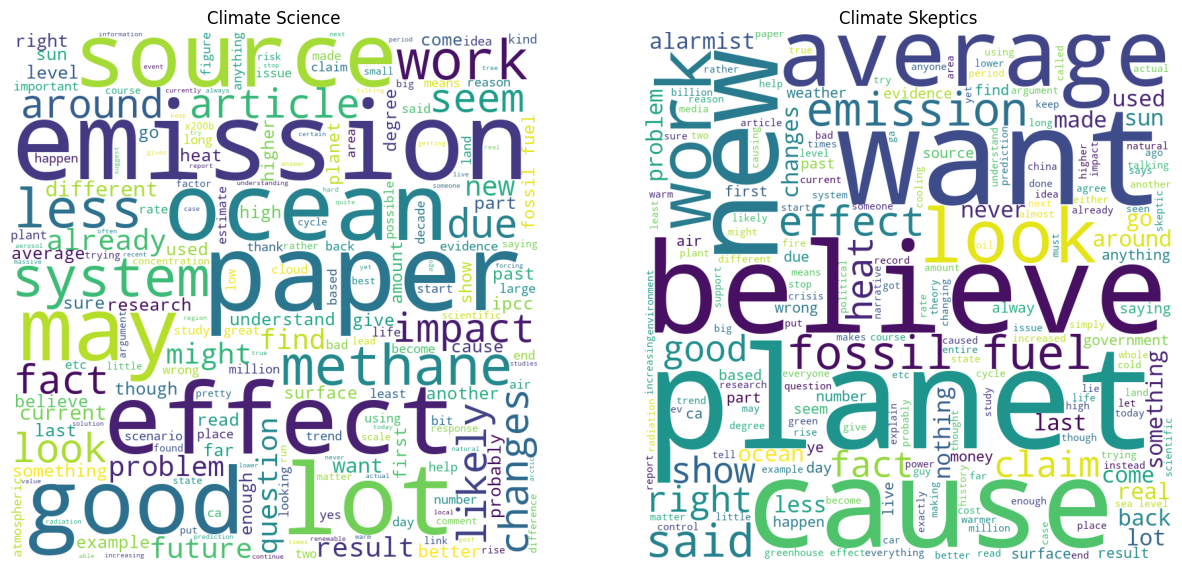

In [97]:
#word cloud for climate science and climate skeptics in subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

wordcloud_cli_sci = WordCloud(width=800, height=800, background_color='white').generate(' '.join(cli_sci_words))
ax[0].imshow(wordcloud_cli_sci)
ax[0].axis('off')
ax[0].set_title('Climate Science')

wordcloud_cli_skp = WordCloud(width=800, height=800, background_color='white').generate(' '.join(cli_skp_words))
ax[1].imshow(wordcloud_cli_skp)
ax[1].axis('off')
ax[1].set_title('Climate Skeptics')

plt.show()

In [98]:
from collections import Counter

total_cli_sci_words = len(cli_sci_words)
total_cli_skp_words = len(cli_skp_words)

cli_sci_word_freq = Counter({word: count / total_cli_sci_words for word, count in Counter(cli_sci_words).items()})
cli_skp_word_freq = Counter({word: count / total_cli_skp_words for word, count in Counter(cli_skp_words).items()})

print(cli_sci_word_freq.most_common(20))
print(cli_skp_word_freq.most_common(20))


[('emissions', 0.004013203439315348), ('methane', 0.0032807938116402964), ('good', 0.0028995394849053386), ('paper', 0.002367790029196055), ('lot', 0.002357757020597767), ('ocean', 0.00227749295181146), ('heat', 0.0022674599432131715), ('may', 0.0022574269346148828), ('effect', 0.0021871958744268645), ('less', 0.0021771628658285762), ('likely', 0.002116964814238846), ('ipcc', 0.0020968987970422692), ('since', 0.002066799771247404), ('might', 0.0020166347282559623), ('greenhouse', 0.001996568711059385), ('due', 0.0019765026938628086), ('already', 0.0019464036680679436), ('around', 0.0019464036680679436), ('different', 0.0019464036680679436), ('changes', 0.0019263376508713668)]
[('heat', 0.0031185004786949025), ('planet', 0.002897564369862283), ('effect', 0.0028163005137399402), ('gas', 0.002595364404907321), ('greenhouse', 0.0024074417376244036), ('since', 0.002211900583830016), ('oil', 0.0022042820973185466), ('weather', 0.002196663610807077), ('believe', 0.002171268655768845), ('new',

In [99]:
#after we have made a list of common words, we can remove them from the tokenized text
df["tokenized_text"] = df["tokenized_text"].apply(lambda x: [word for word in x if word not in common_words])
df["preprocessed_text"] = df["tokenized_text"].apply(lambda x: ' '.join(x)) # convert back to string, now each observation is a string of words that has been cleaned


### Task 2

In [100]:
 #initialize the vectorizer without any preprocessing
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df["preprocessed_text"]) #fitting and transforming the vectorizer on the preprocessed text 
tfidf_matrix = tfidf_matrix.toarray() #convert object matrix to a matrix
print(tfidf_matrix.shape) 

(2027, 30253)


In [101]:
df["tfidf_vector"] = [vector for vector in tfidf_matrix] #store the vectors in the dataframe for later use

In [102]:
most_prominent_words = ['emission', 'source', 'planet', 'believe']
#find the indices of the most prominent words in the tfidf features 
word_indices = [tfidf_vectorizer.vocabulary_[word] for word in most_prominent_words]
#find the cosine similarity between the most prominent words
cosine_similarities = cosine_similarity(tfidf_matrix[:, word_indices].T)
#store the cosine similarities in a dataframe
cosine_similarities_df = pd.DataFrame(cosine_similarities, columns=most_prominent_words, index=most_prominent_words)
print(cosine_similarities_df)

          emission    source    planet   believe
emission  1.000000  0.078340  0.090723  0.044319
source    0.078340  1.000000  0.119099  0.123720
planet    0.090723  0.119099  1.000000  0.232975
believe   0.044319  0.123720  0.232975  1.000000


### Task 3

In [103]:
# Traning a) Logistic Regression b) Random Forest c) Naive Bayes d) SVM  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

X = np.array(df["tfidf_vector"].values.tolist())
y = df["subreddit"].values
y = np.array([1 if subreddit == 'climate_science' else 0 for subreddit in y]) #convert the subreddit names to binary values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [104]:
def train_and_test(model, X_train, X_test, y_train, y_test):
    time_start = time.time()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    time_elapsed = (time.time() - time_start) / 60
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'time_elapsed(m)': time_elapsed}

In [105]:
classifiers = [
    ("Logistic Regression", LogisticRegression()), 
    ("Random Forest", RandomForestClassifier()), 
    ("Naive Bayes", MultinomialNB()), 
    # ("SVM", SVC())
]
results = {}

for classifier in classifiers:
    name, model = classifier
    results[name] = train_and_test(model, X_train, X_test, y_train, y_test)

c:\Users\randy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
print(json.dumps(results, indent=4))

{
    "Logistic Regression": {
        "accuracy": 0.8399014778325123,
        "precision": 0.9333333333333333,
        "recall": 0.1794871794871795,
        "f1": 0.3010752688172043,
        "time_elapsed(m)": 0.021975270907084146
    },
    "Random Forest": {
        "accuracy": 0.8325123152709359,
        "precision": 0.9166666666666666,
        "recall": 0.14102564102564102,
        "f1": 0.2444444444444444,
        "time_elapsed(m)": 0.3429303765296936
    },
    "Naive Bayes": {
        "accuracy": 0.8078817733990148,
        "precision": 0.0,
        "recall": 0.0,
        "f1": 0.0,
        "time_elapsed(m)": 0.0027773261070251467
    }
}


### Task 4

In [107]:
#function to prune the features
def select_k(k):
    selector = SelectKBest(chi2, k=k)
    X_train_k = selector.fit_transform(X_train, y_train)
    X_test_k = selector.transform(X_test)
    
    return X_train_k, X_test_k

In [108]:
pruned_results = {}

In [109]:
k_s = [25000, 20000, 15000, 10000, 5000]

for k in k_s:
    X_train_k, X_test_k = select_k(k)
    pruned_results[f'RandomForest_{k}'] = train_and_test(RandomForestClassifier(), X_train_k, X_test_k, y_train, y_test)

In [110]:
print(json.dumps(pruned_results, indent=4))

{
    "RandomForest_25000": {
        "accuracy": 0.8300492610837439,
        "precision": 0.8461538461538461,
        "recall": 0.14102564102564102,
        "f1": 0.24175824175824173,
        "time_elapsed(m)": 0.13645134766896566
    },
    "RandomForest_20000": {
        "accuracy": 0.8423645320197044,
        "precision": 0.8888888888888888,
        "recall": 0.20512820512820512,
        "f1": 0.3333333333333333,
        "time_elapsed(m)": 0.13272945483525594
    },
    "RandomForest_15000": {
        "accuracy": 0.8349753694581281,
        "precision": 0.8666666666666667,
        "recall": 0.16666666666666666,
        "f1": 0.2795698924731182,
        "time_elapsed(m)": 0.10364233652750651
    },
    "RandomForest_10000": {
        "accuracy": 0.8374384236453202,
        "precision": 0.875,
        "recall": 0.1794871794871795,
        "f1": 0.2978723404255319,
        "time_elapsed(m)": 0.08831854263941447
    },
    "RandomForest_5000": {
        "accuracy": 0.8399014778325123,


In [111]:
#select top k features using tfidf
def select_k_tfidf(k):
    #sum the tfidf scores for each word
    word_scores = np.sum(tfidf_matrix, axis=0)
    #get the indices of the top k words
    top_k_indices = np.argsort(word_scores)[-k:] #sort the indices in ascending order and get the last k indices
    
    X_train_k = X_train[:, top_k_indices] #select the top k features from the training set
    X_test_k = X_test[:, top_k_indices] #select the top k features from the test set
    
    return X_train_k, X_test_k

In [112]:
pruned_tfidf_results = {}

for k in k_s:
    X_train_k, X_test_k = select_k_tfidf(k)
    pruned_tfidf_results[f'RandomForest_{k}'] = train_and_test(RandomForestClassifier(), X_train_k, X_test_k, y_train, y_test)
    
print(json.dumps(pruned_tfidf_results, indent=4))

{
    "RandomForest_25000": {
        "accuracy": 0.8472906403940886,
        "precision": 0.9444444444444444,
        "recall": 0.21794871794871795,
        "f1": 0.35416666666666674,
        "time_elapsed(m)": 0.1496911406517029
    },
    "RandomForest_20000": {
        "accuracy": 0.8374384236453202,
        "precision": 0.9285714285714286,
        "recall": 0.16666666666666666,
        "f1": 0.2826086956521739,
        "time_elapsed(m)": 0.12486003239949545
    },
    "RandomForest_15000": {
        "accuracy": 0.8349753694581281,
        "precision": 0.8666666666666667,
        "recall": 0.16666666666666666,
        "f1": 0.2795698924731182,
        "time_elapsed(m)": 0.11263551314671834
    },
    "RandomForest_10000": {
        "accuracy": 0.8448275862068966,
        "precision": 0.8571428571428571,
        "recall": 0.23076923076923078,
        "f1": 0.36363636363636365,
        "time_elapsed(m)": 0.10638575951258342
    },
    "RandomForest_5000": {
        "accuracy": 0.8399